In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import math
import os
import sys
import warnings
import argparse
import numpy as np
import yaml
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from multiprocessing import Lock
from multiprocessing.pool import ThreadPool
from multiprocessing import Pool, cpu_count

import time
import threading
import random 
from sklearn import mixture
from sklearn.utils import shuffle
from skimage import measure

from glob import glob
from tqdm import tqdm
import math

from PIL import Image,ImageFilter
import PIL.ImageOps as imop
from glob import glob
from tqdm import tqdm
from torch import optim
from torch import Tensor
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset,Sampler
from torchvision import datasets,transforms
from torch.nn import functional as F

sys.path.append("/home/shiyi/gpu/gpu/")
sys.path.append("/home/shiyi/colposcopy/colposcopy/util")
img_dir_origin = "/data/colposcopy/colposcopy/"
img_dir_modified = "/data/colposcopy/colposcopy_1/"
target_dir = ''
from gpu_allocation import set_gpu

In [ ]:
!ls /home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/

In [3]:
import csv
def bbox_file_reader(file_name):
    csv_path = os.path.join(img_dir_origin,file_name)
    f = open(csv_path)
    f_csv = csv.reader(f)
    pic_dict = {}
    for row, in f_csv:
        type_cur = row.split('\\')[0]
        name_cur = row.split('\\')[1].split()[0]
        num_cur =  int(row.split()[1])
        boxes = [int(x) for x in row.split()[2:6]]
        path = os.path.join(img_dir_origin,'train','_'.join(file_name.split('_')[:2]),name_cur)
        #print([path,boxes])
        label = 0
        if os.path.exists(path):
            label = 1
            pic_dict[path] = boxes
            #print([path,boxes])
    f.close()
    return pic_dict

index = 0
def bboxes_file_writer(bboxes_lst):  
    par_dir = "/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels"
    def bbox_file_writer(bbox):
        
        label_table = {"Type_1":0,"Type_2":1,"Type_3":2} 
        origin_path,coords = bbox
        
        name = origin_path.split('/')[-1].split('.')[0]
        target_path = os.path.join(par_dir,name +'.txt')
        label_index = str(label_table[origin_path.split('/')[-2]])
        img = cv2.imread(origin_path)
        img_height,img_width,_ = img.shape
        center_height = str(int(coords[1]+(coords[3]-1)/2)*1.0/img_height)
        center_width = str(int(coords[0]+(coords[2]-1)/2)*1.0/img_width)
        box_height = str(coords[3]*1.0/img_height)
        box_width = str(coords[2]*1.0/img_width)
        text = ' '.join([label_index,center_width,center_height,box_width,box_height])
        f = open(target_path,'w')
        f.write(text+'\n')   
        f.close()
        
        global index
        index += 1
        print (index,text)
        return name
    object_name_lst =  map(lambda x:bbox_file_writer(x),bboxes_lst)
    return
    
bbox_1 = bbox_file_reader("Type_1_bbox.tsv").items()
bbox_2 = bbox_file_reader("Type_2_bbox.tsv").items()
bbox_3 = bbox_file_reader("Type_3_bbox.tsv").items()

val_total_percentage = 0.2
bbox_1_split_index = int(0.2*len(bbox_1))
bbox_2_split_index = int(0.2*len(bbox_2))
bbox_3_split_index = int(0.2*len(bbox_3))

bbox_valid = shuffle(bbox_1[:bbox_1_split_index]+bbox_2[:bbox_2_split_index]+bbox_3[:bbox_3_split_index])
bbox_train = shuffle(bbox_1[bbox_1_split_index:]+bbox_2[bbox_2_split_index:]+bbox_3[bbox_3_split_index:])
bbox_all = bbox_train+bbox_valid
#print(len(bbox_valid))
#print(len(bbox_train))

#bboxes_file_writer(bbox_all)

1 2 0.483251633987 0.350796568627 0.161764705882 0.231004901961
2 2 0.60142118863 0.408430232558 0.31330749354 0.305959302326
3 1 0.409560723514 0.393653100775 0.607881136951 0.414728682171
4 1 0.468545751634 0.444240196078 0.25 0.20925245098
5 1 0.40665374677 0.657218992248 0.515503875969 0.375968992248
6 1 0.564133986928 0.407781862745 0.251633986928 0.195159313725
7 1 0.475490196078 0.525735294118 0.278594771242 0.186580882353
8 1 0.664728682171 0.5 0.267926356589 0.35142118863
9 2 0.505208333333 0.362745098039 0.392156862745 0.368055555556
10 2 0.451899509804 0.12704248366 0.155637254902 0.198120915033
11 0 0.418300653595 0.384191176471 0.165849673203 0.14368872549
12 2 0.421977124183 0.570772058824 0.196078431373 0.193321078431
13 2 0.41135620915 0.418198529412 0.218954248366 0.142156862745
14 1 0.477532679739 0.683517156863 0.308823529412 0.261335784314
15 2 0.474673202614 0.561580882353 0.15114379085 0.114583333333
16 1 0.542892156863 0.609068627451 0.281045751634 0.181066176471

129 1 0.616279069767 0.451308139535 0.627260981912 0.380813953488
130 1 0.317810457516 0.472120098039 0.231209150327 0.185661764706
131 1 0.59980620155 0.326792635659 0.578811369509 0.430717054264
132 1 0.487080103359 0.514292635659 0.486434108527 0.298449612403
133 2 0.422157622739 0.301841085271 0.578811369509 0.320009689922
134 2 0.318218954248 0.561580882353 0.308823529412 0.328431372549
135 0 0.388888888889 0.298713235294 0.379901960784 0.356004901961
136 0 0.461563307494 0.564680232558 0.297157622739 0.322916666667
137 1 0.410130718954 0.491727941176 0.244281045752 0.230085784314
138 1 0.550245098039 0.511029411765 0.184640522876 0.138174019608
139 2 0.513888888889 0.506740196078 0.113562091503 0.15625
140 0 0.585271317829 0.573158914729 0.445090439276 0.383478682171
141 1 0.477124183007 0.415441176471 0.414215686275 0.225183823529
142 1 0.460594315245 0.584302325581 0.761627906977 0.457364341085
143 1 0.420219638243 0.512839147287 0.34496124031 0.314437984496
144 1 0.47508169934

255 1 0.612080103359 0.276162790698 0.687338501292 0.259689922481
256 2 0.438725490196 0.563725490196 0.345588235294 0.269914215686
257 1 0.470284237726 0.512596899225 0.777131782946 0.578730620155
258 2 0.517156862745 0.578737745098 0.392973856209 0.190257352941
259 2 0.508397932817 0.565406976744 0.659560723514 0.440406976744
260 2 0.435866013072 0.265625 0.253267973856 0.151348039216
261 0 0.477713178295 0.468507751938 0.43669250646 0.43386627907
262 1 0.409237726098 0.525678294574 0.334625322997 0.298449612403
263 1 0.560400516796 0.697674418605 0.237726098191 0.204699612403
264 1 0.558139534884 0.495397286822 0.314599483204 0.334302325581
265 1 0.440767973856 0.489276960784 0.27614379085 0.210477941176
266 2 0.482434640523 0.536151960784 0.235294117647 0.16574754902
267 1 0.430147058824 0.309129901961 0.238562091503 0.106004901961
268 0 0.565767973856 0.545955882353 0.387254901961 0.382352941176
269 1 0.357843137255 0.388786764706 0.549836601307 0.46568627451
270 1 0.541258169935 

382 1 0.528746770026 0.496850775194 0.329457364341 0.348352713178
383 1 0.553921568627 0.443321078431 0.316176470588 0.262254901961
384 1 0.509803921569 0.379901960784 0.371732026144 0.207414215686
385 1 0.503875968992 0.554505813953 0.548449612403 0.310562015504
386 1 0.586192810458 0.654411764706 0.245098039216 0.216911764706
387 1 0.445090439276 0.298449612403 0.344315245478 0.311531007752
388 1 0.485142118863 0.459302325581 0.18023255814 0.250968992248
389 1 0.361111111111 0.355377906977 0.240956072351 0.222625968992
390 2 0.687338501292 0.625242248062 0.485142118863 0.393168604651
391 1 0.502583979328 0.386143410853 0.202196382429 0.227470930233
392 0 0.36887254902 0.353860294118 0.25 0.25
393 1 0.467320261438 0.34375 0.410947712418 0.31556372549
394 2 0.484885620915 0.316482843137 0.218954248366 0.266237745098
395 2 0.326797385621 0.340073529412 0.437091503268 0.336090686275
396 0 0.581699346405 0.441789215686 0.487745098039 0.342524509804
397 1 0.245801033592 0.490310077519 0.22

509 1 0.499677002584 0.697674418605 0.231266149871 0.170300387597
510 2 0.493055555556 0.610906862745 0.442810457516 0.321078431373
511 0 0.549741602067 0.478924418605 0.18023255814 0.200823643411
512 1 0.544896640827 0.414970930233 0.701550387597 0.570978682171
513 2 0.596405228758 0.242953431373 0.146241830065 0.142156862745
514 2 0.507761437908 0.458026960784 0.218954248366 0.289522058824
515 1 0.465277777778 0.69362745098 0.230392156863 0.147671568627
516 1 0.420542635659 0.479408914729 0.596253229974 0.512354651163
517 2 0.604575163399 0.418504901961 0.358660130719 0.305759803922
518 2 0.522467320261 0.552696078431 0.609477124183 0.32199754902
519 2 0.348447712418 0.54381127451 0.137254901961 0.106924019608
520 1 0.626633986928 0.498161764706 0.479575163399 0.398897058824
521 1 0.611519607843 0.406862745098 0.312091503268 0.166666666667
522 2 0.46511627907 0.411579457364 0.517441860465 0.3125
523 1 0.487820512821 0.444230769231 0.467307692308 0.491346153846
524 1 0.362726098191 0.

635 1 0.457687338501 0.326550387597 0.152454780362 0.0908430232558
636 2 0.627450980392 0.547487745098 0.347222222222 0.231924019608
637 1 0.513141025641 0.660336538462 0.325641025641 0.258413461538
638 1 0.542075163399 0.442401960784 0.245098039216 0.169424019608
639 2 0.40826873385 0.503149224806 0.31976744186 0.237645348837
640 1 0.543604651163 0.450823643411 0.394056847545 0.421511627907
641 1 0.418709150327 0.589460784314 0.40522875817 0.212009803922
642 1 0.466094771242 0.424325980392 0.395424836601 0.336090686275
643 0 0.43954248366 0.498161764706 0.149509803922 0.12806372549
644 0 0.458979328165 0.414970930233 0.226098191214 0.241521317829
645 0 0.406976744186 0.360949612403 0.363695090439 0.179021317829
646 1 0.491925064599 0.560319767442 0.366925064599 0.251937984496
647 1 0.410206718346 0.426356589147 0.613049095607 0.429021317829
648 1 0.638071895425 0.429534313725 0.249183006536 0.19699754902
649 1 0.397058823529 0.445772058824 0.206699346405 0.212316176471
650 1 0.6088501

761 1 0.552325581395 0.43144379845 0.118217054264 0.200581395349
762 1 0.416666666667 0.486825980392 0.345588235294 0.234068627451
763 2 0.499183006536 0.610906862745 0.352124183007 0.186580882353
764 2 0.488372093023 0.325339147287 0.371447028424 0.25
765 2 0.56045751634 0.620404411765 0.236111111111 0.129595588235
766 2 0.35089869281 0.447610294118 0.174836601307 0.204350490196
767 1 0.395025839793 0.537063953488 0.531007751938 0.463178294574
768 1 0.461563307494 0.47117248062 0.503875968992 0.420542635659
769 2 0.497549019608 0.444240196078 0.209967320261 0.143075980392
770 0 0.500322997416 0.568798449612 0.162790697674 0.280281007752
771 0 0.582687338501 0.31613372093 0.585917312661 0.575823643411
772 0 0.613695090439 0.357558139535 0.31007751938 0.248062015504
773 2 0.533591731266 0.382751937984 0.354651162791 0.286821705426
774 2 0.483204134367 0.550387596899 0.485142118863 0.510416666667
775 1 0.401960784314 0.378982843137 0.214869281046 0.160232843137
776 0 0.545865633075 0.420

887 2 0.533905228758 0.507965686275 0.380718954248 0.164828431373
888 2 0.532679738562 0.48743872549 0.157679738562 0.183517156863
889 1 0.464470284238 0.516230620155 0.288759689922 0.288759689922
890 2 0.409722222222 0.371629901961 0.254901960784 0.248161764706
891 1 0.395671834625 0.469476744186 0.341085271318 0.31613372093
892 2 0.394056847545 0.653100775194 0.326227390181 0.380813953488
893 1 0.607881136951 0.516230620155 0.327519379845 0.260416666667
894 1 0.561274509804 0.524816176471 0.316176470588 0.307904411765
895 2 0.500408496732 0.391544117647 0.295751633987 0.149509803922
896 1 0.422480620155 0.488372093023 0.354651162791 0.221656976744
897 0 0.548202614379 0.412990196078 0.324346405229 0.249080882353
898 0 0.490310077519 0.345930232558 0.455426356589 0.366521317829
899 0 0.535576923077 0.391346153846 0.614102564103 0.620432692308
900 1 0.496447028424 0.345445736434 0.343669250646 0.350532945736
901 2 0.573529411765 0.46262254902 0.191993464052 0.204656862745
902 2 0.52083

1013 1 0.325581395349 0.402131782946 0.372739018088 0.380813953488
1014 1 0.479974160207 0.297480620155 0.343023255814 0.243217054264
1015 2 0.511029411765 0.605392156863 0.253267973856 0.14675245098
1016 0 0.645833333333 0.460817307692 0.466666666667 0.596634615385
1017 2 0.508720930233 0.410125968992 0.717054263566 0.684593023256
1018 2 0.487745098039 0.502450980392 0.15931372549 0.161151960784
1019 1 0.473039215686 0.366421568627 0.34068627451 0.258578431373
1020 0 0.251633986928 0.304534313725 0.258986928105 0.280330882353
1021 1 0.444121447028 0.460029069767 0.459948320413 0.413032945736
1022 1 0.446078431373 0.448529411765 0.376633986928 0.30300245098
1023 2 0.542075163399 0.574754901961 0.18137254902 0.15625
1024 2 0.52410130719 0.58425245098 0.31862745098 0.362745098039
1025 0 0.53811369509 0.567829457364 0.481266149871 0.361918604651
1026 2 0.434129901961 0.424836601307 0.204656862745 0.200571895425
1027 0 0.396650326797 0.311580882353 0.43137254902 0.408088235294
1028 2 0.462

1138 2 0.485702614379 0.576286764706 0.232026143791 0.143995098039
1139 2 0.482434640523 0.505514705882 0.236928104575 0.217830882353
1140 2 0.465277777778 0.372242647059 0.478758169935 0.393075980392
1141 1 0.555555555556 0.421568627451 0.247549019608 0.182904411765
1142 2 0.53811369509 0.494428294574 0.207364341085 0.243217054264
1143 2 0.569852941176 0.375612745098 0.218954248366 0.193321078431
1144 0 0.550653594771 0.335784313725 0.206699346405 0.117340686275
1145 1 0.368863049096 0.295542635659 0.395994832041 0.22238372093
1146 2 0.537990196078 0.555453431373 0.28431372549 0.244485294118
1147 0 0.453431372549 0.578125 0.40114379085 0.357843137255
1148 2 0.43954248366 0.417279411765 0.308006535948 0.310661764706
1149 2 0.498062015504 0.441860465116 0.133236434109 0.172157622739
1150 0 0.483251633987 0.467524509804 0.245098039216 0.157169117647
1151 1 0.208979328165 0.617490310078 0.240310077519 0.150678294574
1152 1 0.637596899225 0.49878875969 0.233204134367 0.145833333333
1153 2 

1263 1 0.516795865633 0.647044573643 0.352067183463 0.239583333333
1264 2 0.433823529412 0.654105392157 0.30637254902 0.219669117647
1265 1 0.517565359477 0.550551470588 0.450980392157 0.3125
1266 2 0.482881136951 0.396075581395 0.293281653747 0.195978682171
1267 1 0.56007751938 0.638323643411 0.463178294574 0.290697674419
1268 0 0.458979328165 0.523255813953 0.365633074935 0.481104651163
1269 2 0.415032679739 0.515625 0.0972222222222 0.0986519607843
1270 2 0.465073529412 0.50612745098 0.125612745098 0.115604575163
1271 0 0.492238562092 0.691789215686 0.285947712418 0.25
1272 1 0.505490956072 0.594476744186 0.273901808786 0.280281007752
1273 1 0.540441176471 0.412071078431 0.218954248366 0.14675245098
1274 1 0.434640522876 0.652573529412 0.187091503268 0.124080882353
1275 1 0.484477124183 0.482230392157 0.229575163399 0.230085784314
1276 2 0.409237726098 0.428779069767 0.490956072351 0.390261627907
1277 1 0.546834625323 0.543120155039 0.395348837209 0.435562015504
1278 2 0.60089869281 

1388 1 0.477390180879 0.544331395349 0.415374677003 0.428052325581
1389 2 0.502859477124 0.474571078431 0.426470588235 0.212928921569
1390 1 0.253552971576 0.303052325581 0.229974160207 0.271802325581
1391 1 0.59681372549 0.456495098039 0.359477124183 0.379901960784
1392 2 0.665032679739 0.543198529412 0.330882352941 0.195159313725
1393 0 0.470284237726 0.310319767442 0.709948320413 0.382509689922
1394 1 0.571059431525 0.490552325581 0.259043927649 0.188468992248
1395 0 0.478359173127 0.335029069767 0.339793281654 0.278343023256
1396 0 0.552325581395 0.515019379845 0.463178294574 0.509447674419
1397 0 0.492647058824 0.644914215686 0.566176470588 0.582107843137
1398 1 0.514211886305 0.473110465116 0.203488372093 0.204457364341
1399 2 0.413807189542 0.385110294118 0.287581699346 0.151654411765
1400 2 0.469638242894 0.610465116279 0.345607235142 0.282218992248
1401 1 0.47589869281 0.388786764706 0.243464052288 0.208333333333
1402 1 0.454134366925 0.449612403101 0.30684754522 0.30692829457

In [13]:
#import piexif
#piexif.remove(img)

yolo_train_table = "/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/train.txt"
yolo_valid_table = "/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/valid.txt"
remove_table_path = "/data/colposcopy/colposcopy/removed_files.csv"

f = open(remove_table_path,'r')
rm_lst = f.readlines()[1:]
rm_lst = map(lambda x: str(x.strip().split(',')[0]),rm_lst)
#print (rm_lst)
pic_set = set([])

with open(yolo_train_table,'w') as f:
    for i in bbox_train:
        if i[0].split('/')[-1] in rm_lst or not os.path.exists(i[0]):
            continue
        f.write(i[0]+'\n')
with open(yolo_valid_table,'w') as f:
    for i in bbox_valid:
        print( i[0].split('/')[-1])
        if i[0].split('/')[-1]  in rm_lst or not os.path.exists(i[0]):
            continue
        f.write(i[0]+'\n')

['1015.jpg', '1018.jpg', '1028.jpg', '1042.jpg', '1090.jpg', '1094.jpg', '114.jpg', '1175.jpg', '1186.jpg', '1205.jpg', '1220.jpg', '1252.jpg', '1261.jpg', '128.jpg', '1285.jpg', '1295.jpg', '1319.jpg', '1331.jpg', '1347.jpg', '136.jpg', '1444.jpg', '145.jpg', '1468.jpg', '1479.jpg', '1490.jpg', '1509.jpg', '1510.jpg', '1537.jpg', '1550.jpg', '1551.jpg', '1563.jpg', '1575.jpg', '1600.jpg', '1605.jpg', '1638.jpg', '1668.jpg', '1702.jpg', '1739.jpg', '1762.jpg', '1794.jpg', '1799.jpg', '1822.jpg', '1825.jpg', '1835.jpg', '1843.jpg', '1844.jpg', '1850.jpg', '1854.jpg', '1856.jpg', '186.jpg', '1861.jpg', '1865.jpg', '1876.jpg', '1913.jpg', '1914.jpg', '1916.jpg', '1952.jpg', '199.jpg', '2006.jpg', '2010.jpg', '2047.jpg', '2060.jpg', '2064.jpg', '2071.jpg', '2151.jpg', '2163.jpg', '2177.jpg', '2185.jpg', '2189.jpg', '2195.jpg', '2218.jpg', '2233.jpg', '2240.jpg', '2273.jpg', '2320.jpg', '238.jpg', '2400.jpg', '2414.jpg', '2452.jpg', '247.jpg', '248.jpg', '2491.jpg', '2511.jpg', '253.jpg', '

In [12]:
!wc -l /home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/valid.txt
!wc -l /home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/train.txt
!ls /data/colposcopy/colposcopy/
!ls /home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/images

437 /home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/valid.txt
1713 /home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/train.txt
extra		     removed_files.csv		 test	     Type_1_bbox.tsv
fixed_labels_v2.csv  sample_submission.csv	 test_stg2   Type_2_bbox.tsv
ObjectMarker2.py     sample_submission_stg2.csv  train	     Type_3_bbox.tsv
proxy		     solution_stg1_release.csv	 train_stg2


In [344]:
from glob import glob
import matplotlib.pyplot as plt
import cv2

classes = ['Type_1','Type_2','Type_3']
def index_of_one(lst):
    for i in range(len(lst)):
        if lst[i]=='1':
            return i
        
def cvt(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
test_origin_paths = glob("/data/colposcopy/colposcopy/test/*") 
paths = glob("/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/output/*")
ground_truth_file = open("/data/colposcopy/colposcopy/solution_stg1_release.csv")
ground_truth = ground_truth_file.readlines()[1:]
ground_truth = map(lambda x:x.strip('\n').split(','),ground_truth)
ground_truth_table = map(lambda x:[x[0].split('.')[0],index_of_one(x[1:])],ground_truth)
print (ground_truth_table)




[['0', 1], ['1', 1], ['2', 0], ['3', 2], ['4', 2], ['5', 1], ['6', 1], ['7', 1], ['8', 1], ['9', 1], ['10', 1], ['11', 2], ['12', 1], ['13', 2], ['14', 1], ['15', 2], ['16', 0], ['17', 1], ['18', 1], ['19', 2], ['20', 0], ['21', 1], ['22', 1], ['23', 0], ['24', 1], ['25', 0], ['26', 1], ['27', 2], ['28', 1], ['29', 2], ['30', 0], ['31', 1], ['32', 1], ['33', 0], ['34', 1], ['35', 2], ['36', 1], ['37', 1], ['38', 1], ['39', 0], ['40', 2], ['41', 1], ['42', 1], ['43', 1], ['44', 0], ['45', 2], ['46', 0], ['47', 0], ['48', 2], ['49', 2], ['50', 2], ['51', 0], ['52', 2], ['53', 0], ['54', 2], ['55', 2], ['56', 1], ['57', 1], ['58', 1], ['59', 0], ['60', 2], ['61', 1], ['62', 2], ['63', 1], ['64', 1], ['65', 0], ['66', 2], ['67', 2], ['68', 2], ['69', 2], ['70', 0], ['71', 1], ['72', 1], ['73', 0], ['74', 2], ['75', 0], ['76', 2], ['77', 1], ['78', 2], ['79', 0], ['80', 1], ['81', 1], ['82', 1], ['83', 2], ['84', 0], ['85', 1], ['86', 2], ['87', 2], ['88', 1], ['89', 2], ['90', 0], ['91', 1

['/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/output/5.png', '/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/output/449.png', '/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/output/174.png', '/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/output/433.png', '/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/output/432.png', '/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/output/94.png', '/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/output/436.png', '/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/output/164.png', '/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/output/367.png', '/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/output/61.png', '/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/output/279.png', '/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/output/204.png', '/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/output/452.png', '/home/shiyi/colposcopy/colposcopy/models

('ground truth:', [['0', 1], ['1', 1], ['2', 0], ['3', 2]])


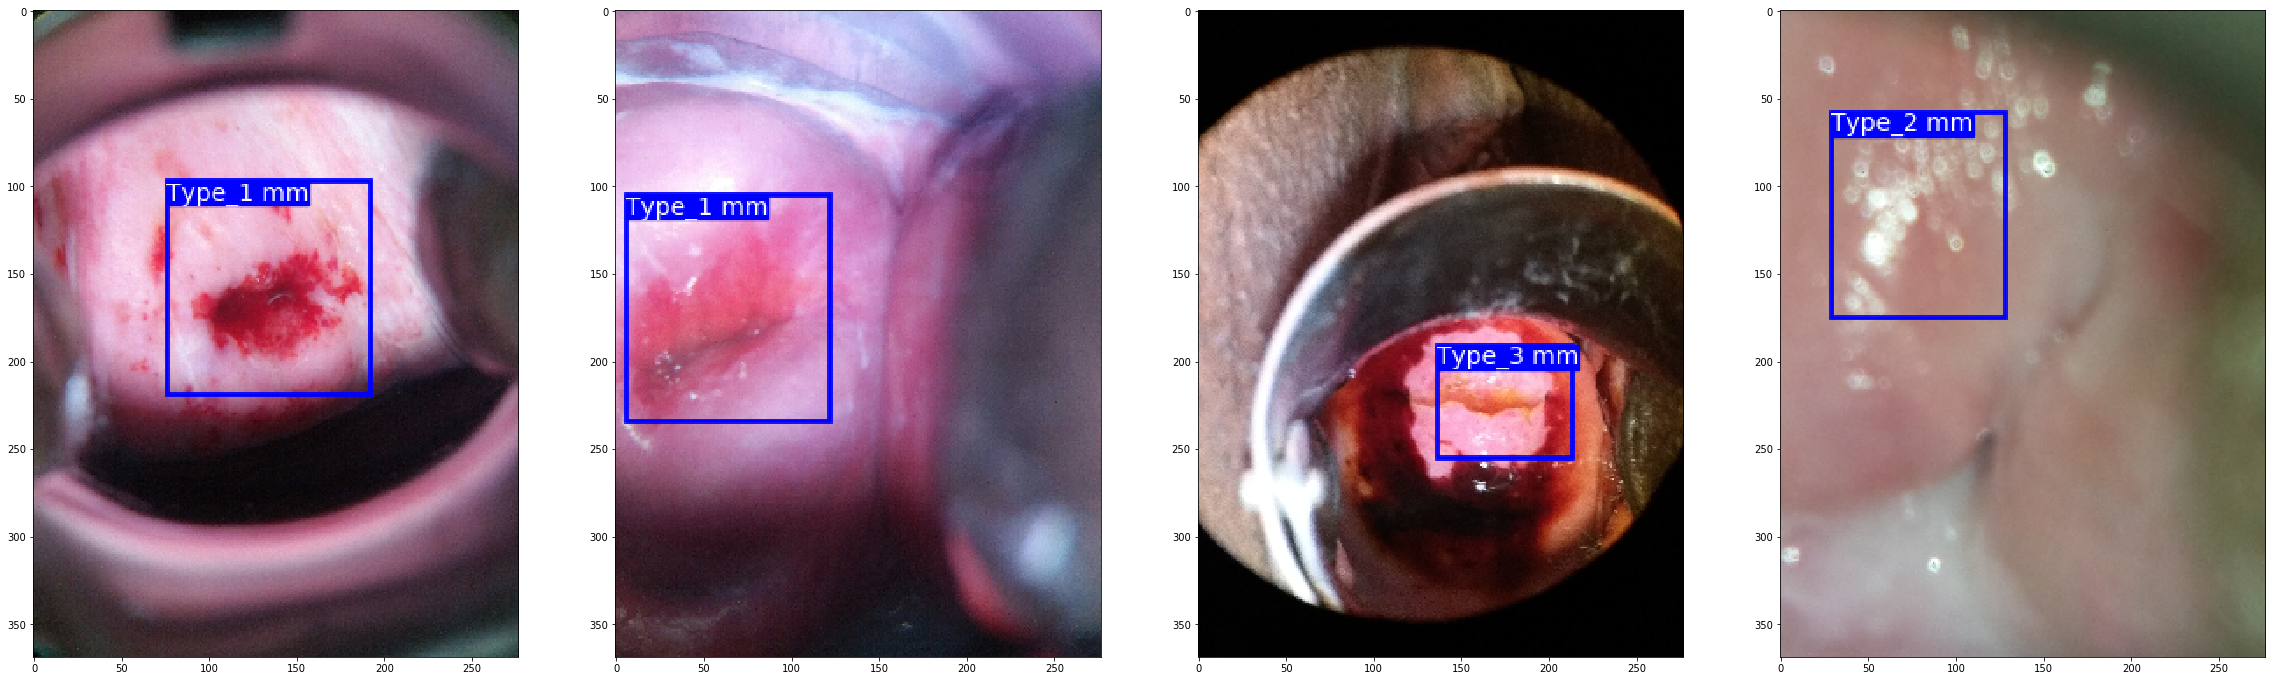

In [345]:
print(paths)
def show(start,paths,stride):
    plt.figure(figsize=(40,40))
    for i in range(start,start+stride):
        img = cv2.imread(paths[i])
        plt.subplot(100+stride*10+i-start+1)
        plt.imshow(cvt(img))
    gt = [ground_truth_table[i] for i in  range(start,start+stride)]
    print ("ground truth:", gt)
        
show(0,paths,4)



/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/output/433.png


<Figure size 432x288 with 0 Axes>

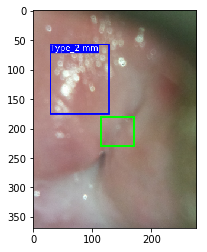

In [372]:
from matplotlib import patches

index = 3
path = paths[index]
print(path)
img = cvt(cv2.imread(path))
plt.figure()
fig, ax = plt.subplots(1)
ax.imshow(img)

x1 = 115
y1 = 180
x2 = 170
y2 = 230


box_w = x2-x1
box_h = y2-y1
bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=(0,1,0), facecolor="none")
ax.add_patch(bbox)


In [283]:
def save_test_bbox(path,x1,y1,x2,y2):
    bbox_test_file = open("/data/colposcopy/colposcopy/bbox_test.tsv",'a')
    path = path.split('/')[-1].split('.')[0]
    bbox = ' '.join([path,str(x1),str(y1),str(x2),str(y2)])+'\n'
    bbox_test_file.write(bbox)
    bbox_test_file.close()
save_test_bbox(path,x1,y1,x2,y2)

In [318]:
import os
import cv2

target = "/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels"
origin = "/data/colposcopy/colposcopy/test"
index_lst = []
with open("/data/colposcopy/colposcopy/bbox_test.tsv") as f:
    test_boxes = f.readlines() 
    for line in test_boxes:
        items = line.strip('\n').split()
        name = items[0]
        index_lst.append(int(name))
        label_index = str(ground_truth_table[int(name)][1])
        target_path = os.path.join(target,name+'_test.txt')
        original_path = os.path.join(origin,name+'_test.jpg')
        coords = map(lambda x:int(x),items[1:])
        img = cv2.imread(original_path)
        img_height,img_width,_ = img.shape
        center_height = str(int(coords[1]+(coords[3]-1)/2)*1.0/img_height)
        center_width = str(int(coords[0]+(coords[2]-1)/2)*1.0/img_width)
        box_height = str(coords[3]*1.0/img_height)
        box_width = str(coords[2]*1.0/img_width)
        text = ' '.join([label_index,center_width,center_height,box_width,box_height])
        f = open(target_path,'w')
        f.write(text+'\n')   
        f.close()

In [464]:
!wc -l /data/colposcopy/colposcopy/bbox_test.tsv
!wc -l /data/colposcopy/colposcopy/solution_stg1_release.csv


508 /data/colposcopy/colposcopy/bbox_test.tsv
513 /data/colposcopy/colposcopy/solution_stg1_release.csv
143_test.jpg,0,0,1
40_test.jpg,0,0,1
327_test.jpg,0,1,0
223_test.jpg,0,0,1


In [379]:
test_img_path = "/data/colposcopy/colposcopy/test"
f_bbox = open("/data/colposcopy/colposcopy/bbox_test.tsv",'r')

lines = f_bbox.readlines()
bbox_table = {}

ground_truth_file = open("/data/colposcopy/colposcopy/solution_stg1_release.csv")
ground_truth = ground_truth_file.readlines()[1:]
ground_truth = map(lambda x:x.strip('\n').split(','),ground_truth)
ground_truth_table = map(lambda x:[x[0].split('.')[0],index_of_one(x[1:])],ground_truth)

for line in lines:
    items = line.strip('\n').split()
    name_img =  items[0]
    coords = map(lambda x:int(x),items[1:])
    name_in_gt_file = name_img.split('_')[0]
    label_index = ground_truth_table[int(name_in_gt_file)][1]
    bbox_table[name_img] = [label_index,coords]
print(bbox_table)

{'318_test': [1, [914, 2120, 1761, 2980]], '241_test': [1, [1095, 1275, 2855, 3208]], '49_test': [2, [479, 901, 1578, 2047]], '94_test': [1, [622, 1729, 1829, 3105]], '201_test': [1, [21, 1140, 1637, 2815]], '188_test': [1, [2171, 823, 2935, 1744]], '248_test': [0, [1106, 1249, 2524, 2822]], '417_test': [1, [673, 680, 2332, 2712]], '503_test': [1, [727, 1505, 1268, 1942]], '109_test': [2, [843, 1183, 1636, 1898]], '79_test': [0, [455, 959, 2215, 2809]], '448_test': [1, [410, 1295, 1787, 2582]], '309_test': [2, [1205, 1968, 1975, 2774]], '226_test': [1, [550, 1112, 1262, 1901]], '346_test': [1, [355, 945, 1939, 2358]], '323_test': [2, [869, 1529, 2502, 2878]], '305_test': [1, [531, 551, 1577, 1856]], '24_test': [1, [564, 736, 1631, 1770]], '286_test': [1, [940, 1269, 2202, 2703]], '293_test': [0, [431, 1890, 1850, 3437]], '266_test': [2, [1386, 758, 2244, 1564]], '133_test': [2, [667, 1369, 1352, 2065]], '228_test': [1, [713, 749, 2134, 2189]], '90_test': [0, [1159, 1182, 1711, 1744]], 

511
[1200, 2200, 1900, 2800]


<Figure size 432x288 with 0 Axes>

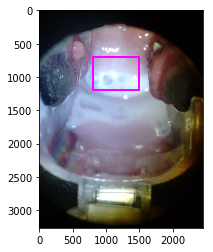

In [484]:
index = 40
file_name = str(index)+"_test"
print(len(bbox_table))
#pred_label, pred_coords = bbox_table[file_name]
incorrect_img_path = os.path.join(test_img_path,file_name)+ ".jpg"
print(pred_coords)
img = cv2.imread(incorrect_img_path)

plt.figure()
fig, ax = plt.subplots(1)
ax.imshow(cvt(img))


#x1 = pred_coords[0]
#y1 = pred_coords[1]
#x2 = pred_coords[2]
#y2 = pred_coords[3]

#box_w = x2-x1
#box_h = y2-y1
#bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=(0,1,0), facecolor="none")
#ax.add_patch(bbox)

x1_mod = 800
y1_mod = 700
x2_mod = 1500
y2_mod = 1200
box_w = x2_mod-x1_mod
box_h = y2_mod-y1_mod
bbox = patches.Rectangle((x1_mod, y1_mod), box_w, box_h, linewidth=2, edgecolor=(1,0,1), facecolor="none")
ax.add_patch(bbox)


In [485]:
bbox_table[file_name] = [2,[x1_mod,y1_mod,x2_mod,y2_mod]]

In [486]:
for i in range(512):
    name = str(i)+"_test"
    if name not in bbox_table:
        print(name)
!cat /data/colposcopy/colposcopy/solution_stg1_release.csv | grep 143_
!cat /data/colposcopy/colposcopy/solution_stg1_release.csv | grep ^40_
!cat /data/colposcopy/colposcopy/solution_stg1_release.csv | grep 327_
!cat /data/colposcopy/colposcopy/solution_stg1_release.csv | grep 223_        
        

143_test.jpg,0,0,1
40_test.jpg,0,0,1
327_test.jpg,0,1,0
223_test.jpg,0,0,1


In [491]:
for name in bbox_table:
    
    label_index, coords =bbox_table[name]
    target_path = os.path.join("/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels",name+'.txt')
    original_path = os.path.join("/data/colposcopy/colposcopy/test",name+'.jpg')   
    print(target_path,original_path)
    img = cv2.imread(original_path)
    img_height,img_width,_ = img.shape
    center_height = str(int(coords[1]+(coords[3]-1)/2)*1.0/img_height)
    center_width = str(int(coords[0]+(coords[2]-1)/2)*1.0/img_width)
    box_height = str(coords[3]*1.0/img_height)
    box_width = str(coords[2]*1.0/img_width)
    text = ' '.join([str(label_index),center_width,center_height,box_width,box_height])
    f = open(target_path,'w')
    f.write(text+'\n')   
    f.close()

('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/318_test.txt', '/data/colposcopy/colposcopy/test/318_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/241_test.txt', '/data/colposcopy/colposcopy/test/241_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/49_test.txt', '/data/colposcopy/colposcopy/test/49_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/94_test.txt', '/data/colposcopy/colposcopy/test/94_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/201_test.txt', '/data/colposcopy/colposcopy/test/201_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/188_test.txt', '/data/colposcopy/colposcopy/test/188_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/248_test.txt', '/data/colposcopy/colposcopy/test/248_test.jpg')
('/home/shiyi/col

('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/349_test.txt', '/data/colposcopy/colposcopy/test/349_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/86_test.txt', '/data/colposcopy/colposcopy/test/86_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/75_test.txt', '/data/colposcopy/colposcopy/test/75_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/136_test.txt', '/data/colposcopy/colposcopy/test/136_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/36_test.txt', '/data/colposcopy/colposcopy/test/36_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/85_test.txt', '/data/colposcopy/colposcopy/test/85_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/202_test.txt', '/data/colposcopy/colposcopy/test/202_test.jpg')
('/home/shiyi/colposc

('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/415_test.txt', '/data/colposcopy/colposcopy/test/415_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/414_test.txt', '/data/colposcopy/colposcopy/test/414_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/451_test.txt', '/data/colposcopy/colposcopy/test/451_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/313_test.txt', '/data/colposcopy/colposcopy/test/313_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/403_test.txt', '/data/colposcopy/colposcopy/test/403_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/358_test.txt', '/data/colposcopy/colposcopy/test/358_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/372_test.txt', '/data/colposcopy/colposcopy/test/372_test.jpg')
('/home/shiyi

('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/182_test.txt', '/data/colposcopy/colposcopy/test/182_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/292_test.txt', '/data/colposcopy/colposcopy/test/292_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/206_test.txt', '/data/colposcopy/colposcopy/test/206_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/505_test.txt', '/data/colposcopy/colposcopy/test/505_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/485_test.txt', '/data/colposcopy/colposcopy/test/485_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/35_test.txt', '/data/colposcopy/colposcopy/test/35_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/511_test.txt', '/data/colposcopy/colposcopy/test/511_test.jpg')
('/home/shiyi/c

('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/262_test.txt', '/data/colposcopy/colposcopy/test/262_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/197_test.txt', '/data/colposcopy/colposcopy/test/197_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/32_test.txt', '/data/colposcopy/colposcopy/test/32_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/397_test.txt', '/data/colposcopy/colposcopy/test/397_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/447_test.txt', '/data/colposcopy/colposcopy/test/447_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/135_test.txt', '/data/colposcopy/colposcopy/test/135_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/181_test.txt', '/data/colposcopy/colposcopy/test/181_test.jpg')
('/home/shiyi/c

('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/243_test.txt', '/data/colposcopy/colposcopy/test/243_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/164_test.txt', '/data/colposcopy/colposcopy/test/164_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/354_test.txt', '/data/colposcopy/colposcopy/test/354_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/82_test.txt', '/data/colposcopy/colposcopy/test/82_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/422_test.txt', '/data/colposcopy/colposcopy/test/422_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/463_test.txt', '/data/colposcopy/colposcopy/test/463_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/473_test.txt', '/data/colposcopy/colposcopy/test/473_test.jpg')
('/home/shiyi/c

('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/264_test.txt', '/data/colposcopy/colposcopy/test/264_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/348_test.txt', '/data/colposcopy/colposcopy/test/348_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/70_test.txt', '/data/colposcopy/colposcopy/test/70_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/450_test.txt', '/data/colposcopy/colposcopy/test/450_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/13_test.txt', '/data/colposcopy/colposcopy/test/13_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/435_test.txt', '/data/colposcopy/colposcopy/test/435_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/185_test.txt', '/data/colposcopy/colposcopy/test/185_test.jpg')
('/home/shiyi/col

('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/481_test.txt', '/data/colposcopy/colposcopy/test/481_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/217_test.txt', '/data/colposcopy/colposcopy/test/217_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/42_test.txt', '/data/colposcopy/colposcopy/test/42_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/279_test.txt', '/data/colposcopy/colposcopy/test/279_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/56_test.txt', '/data/colposcopy/colposcopy/test/56_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/356_test.txt', '/data/colposcopy/colposcopy/test/356_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/357_test.txt', '/data/colposcopy/colposcopy/test/357_test.jpg')
('/home/shiyi/col

('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/92_test.txt', '/data/colposcopy/colposcopy/test/92_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/168_test.txt', '/data/colposcopy/colposcopy/test/168_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/23_test.txt', '/data/colposcopy/colposcopy/test/23_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/237_test.txt', '/data/colposcopy/colposcopy/test/237_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/161_test.txt', '/data/colposcopy/colposcopy/test/161_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/127_test.txt', '/data/colposcopy/colposcopy/test/127_test.jpg')
('/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/496_test.txt', '/data/colposcopy/colposcopy/test/496_test.jpg')
('/home/shiyi/col

In [518]:
files = glob("/home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/labels/*.txt")
deic = {}
lineee = set()
for i in files:
    f = open(i,'r')
    line = f.readlines()[0].strip('\n')
    #print(i,line)
    label = line.split()[0]
    
    length = len(line.split())
    lineee.add(length)
    if label not in deic:
        deic[label] = 1
    else:
        deic[label]+=1
print(lineee)
print(len(files))
!cat /home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/train.txt|wc -l
!wc -l /home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/train.txt
!wc -l /home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/valid.txt

set([5])
2732
1713
1713 /home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/train.txt
437 /home/shiyi/colposcopy/colposcopy/models/PyTorch-YOLOv3/data/custom/valid.txt


In [ ]:
!